###### <img src="./logo_UTN.svg" align="right" width="150" /> 

### Procesamiento Digital de Señales

## Trabajo Práctico Nº9: Filtrado digital lineal de ECG (1ra parte).

### Gabriel Cruz

## Enunciado

En esta tarea se pide diseñar dos filtros digitales, uno IIR y otro FIR, siguiendo las consignas de la guía de laboratorio, y respetando la siguiente plantilla de diseño:

ws1 = 0.1 #Hz

wp1 = 0.5 #Hz

wp2 = 30.0 #Hz

ws2 = 45.0 #Hz

Responda las preguntas al final de la guía y presente los resultados de las señales filtradas como se indica en la parte 2.

## Diseño de filtro FIR

In [40]:
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(r'C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

import matplotlib.ticker

In [41]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

#%% Se carga la señal
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

In [42]:
#%% Se realiza la plantilla
# Plantilla
    
# filter design
ripple = 0.0 # dB
atenuacion = 40.0 # dB

ws1 = 0.1 #Hz
wp1 = 0.5 #Hz
wp2 = 30.0 #Hz
ws2 = 45.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,      nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

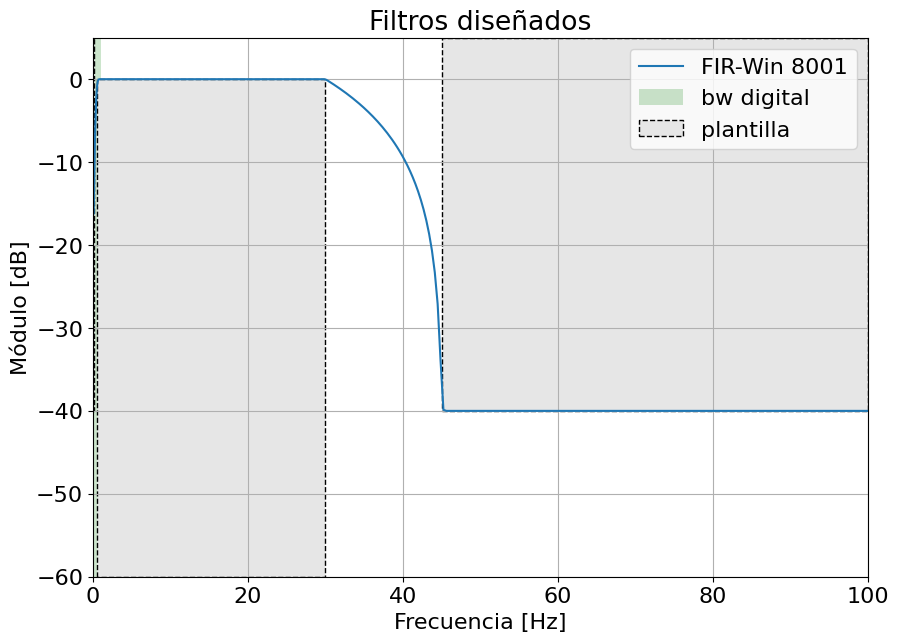

In [43]:
#%%  Se realiza un filtro FIR
cant_coeficientes = 8001

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.8, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


En el grafico de arriba se puede observar la plantilla de un filtro pasabanda y el filtro FIR realizado con la funcion firwin2. Los filtros FIR se destacan por ser siempre estables y tener todos sus polos en el origen.

### Analisis de la  frecuencia inferior

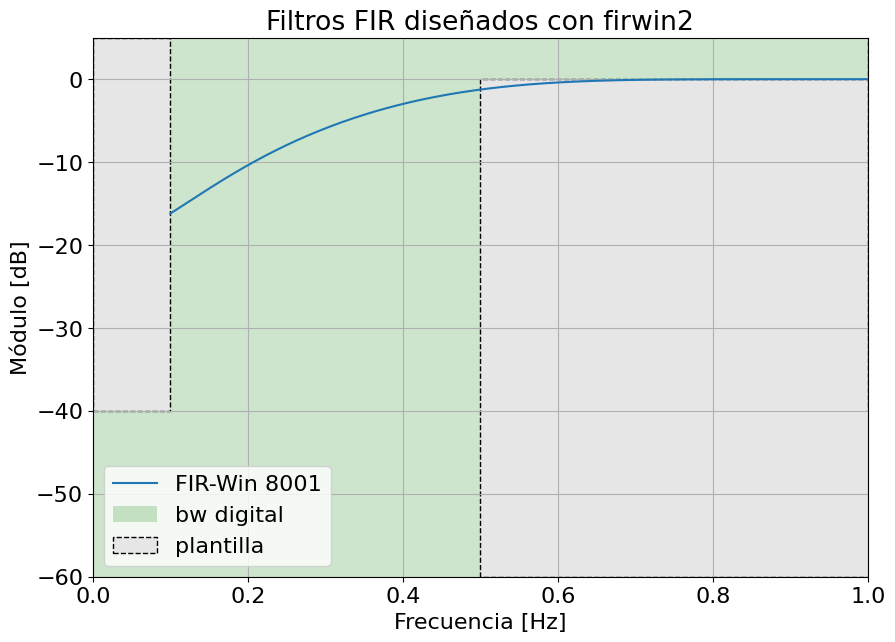

In [44]:
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros FIR diseñados con firwin2')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 1, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


En el grafico de arriba podemos observar que la frecuencia inferior del filtro Firwin2 no estaria cumpliendo con la plantilla de diseño debido a la atenuacion exigente que requiere en la banda de transicion. No grafique la frecuencia superior porque se ve claramente que la cumple.

### Diseño de filtro FIR con Remez

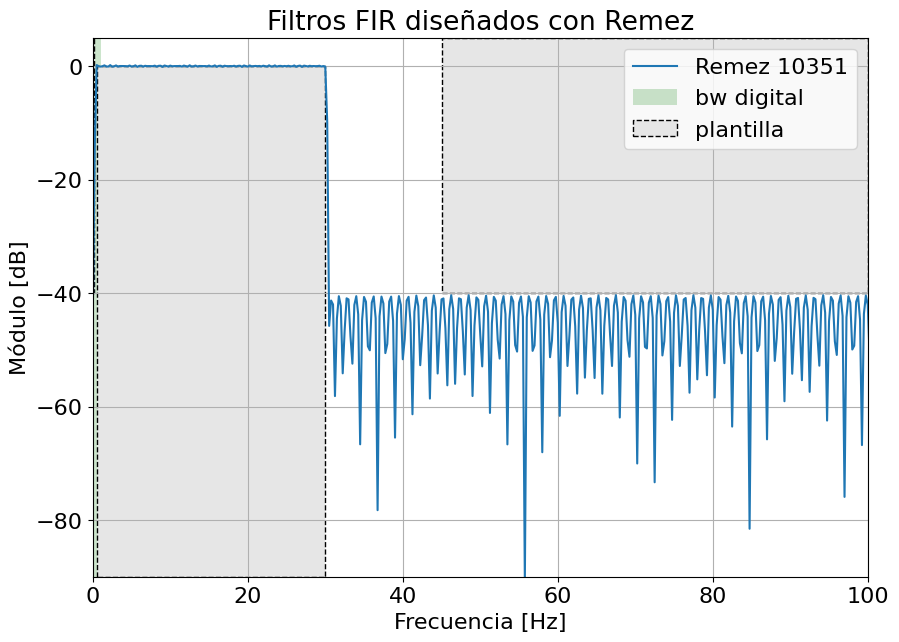

In [45]:

cutoff = 30.0    # Desired cutoff frequency, Hz
trans_width = 0.4  # Width of transition from pass to stop, Hz
numtaps = 4901      # Size of the FIR filter.

edges = [0, cutoff, cutoff + trans_width, nyq_frec]  # Definir las bandas

# Ganancias deseadas: paso (1) hasta la frecuencia de corte y rechazo (0) después de la transición
desired = [1, 0]  # Paso (1) en la banda de paso, Rechazo (0) en la banda de atenuación

taps1 = sig.remez(numtaps, edges, desired, fs=fs)

cutoff = 0.5    # Desired cutoff frequency, Hz
trans_width = 0.4  # Width of transition from pass to stop, Hz
numtaps = 5451      # Size of the FIR filter.

edges = [0,cutoff - trans_width, cutoff, nyq_frec]  # Definir las bandas

# Ganancias deseadas: paso (1) hasta la frecuencia de corte y rechazo (0) después de la transición
desired = [0, 1]  # Paso (1) en la banda de paso, Rechazo (0) en la banda de atenuación

taps2 = sig.remez(numtaps, edges, desired, fs=fs)

num_win = np.convolve(taps1, taps2)
w, hh_win = sig.freqz(num_win, [1], worN=2000, fs=fs)

# _, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
# w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='Remez {:d}'.format(num_win.shape[0]))

plt.title('Filtros FIR diseñados con Remez')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -90, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


En el grafico de arriba se puede observar que se realizo otro filtro FIR con la funcion Remez, este filtro es mas selectivo a comparacion del filtro firwin2. 

#### Analisis de la frecuencia inferior del filtro Remez

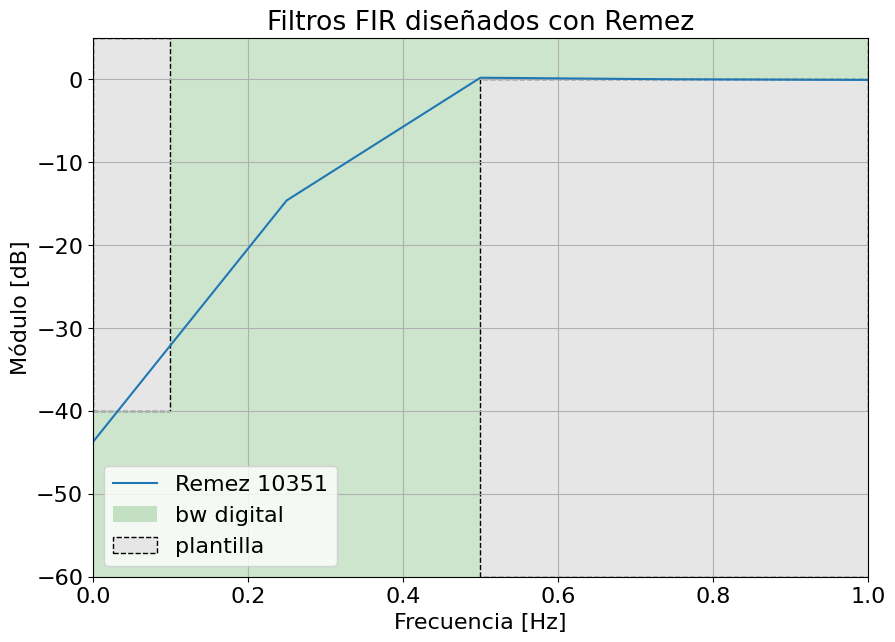

In [46]:
plt.plot(w, 20 * np.log10(abs(hh_win)), label='Remez {:d}'.format(num_win.shape[0]))

plt.title('Filtros FIR diseñados con Remez')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 1, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


En el grafico de arriba se puede observar que al ser un filtro mas selectivo cumple con la plantilla pedida a comparacion del filtro firwin2 que no lograba cumplirla por la exigencia de la atenuacion requerida. No se grafico las frecuencia superior porque se ve claramente que cumple con la plantilla de diseño.

## Diseño de filtro IIR

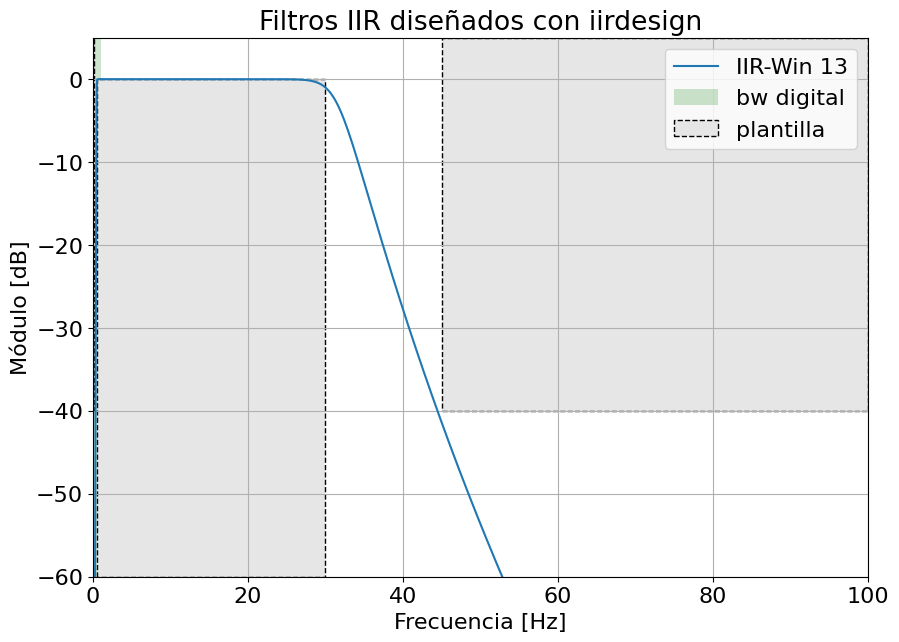

In [47]:
#%% Diseño de Filtro IIR

ripple_IIR= 1
ws = [frecs[1], frecs[4]]
wp = [frecs[2], frecs[3]]

bp_sos_butter = sig.iirdesign(wp,ws, ripple_IIR, atenuacion, ftype='butter', output = 'sos')

# Muestra de frecuencias para calcular la respuesta en frecuencia
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.8, 250))
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True)) / nyq_frec * np.pi

# Respuesta en frecuencia usando sosfreqz
w, h = sig.sosfreqz(bp_sos_butter, worN=w)

# Renormalizar el eje de frecuencia
w = w / np.pi * nyq_frec

plt.figure()
plt.plot(w, 20 * np.log10(abs(h)), label='IIR-Win {:d}'.format(bp_sos_butter.shape[0]))

plt.title('Filtros IIR diseñados con iirdesign')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


En el grafico de arriba se puede observar la plantilla de un filtro pasabanda y el filtro IIR realizado con la funcion iirdesign del tipo Butterworth. Los filtros IIR se destacan por no ser siempre estables, al menos un polo fuera del origen y tienen realimentacion desde la salida.

#### Analisis de frecuencia inferior

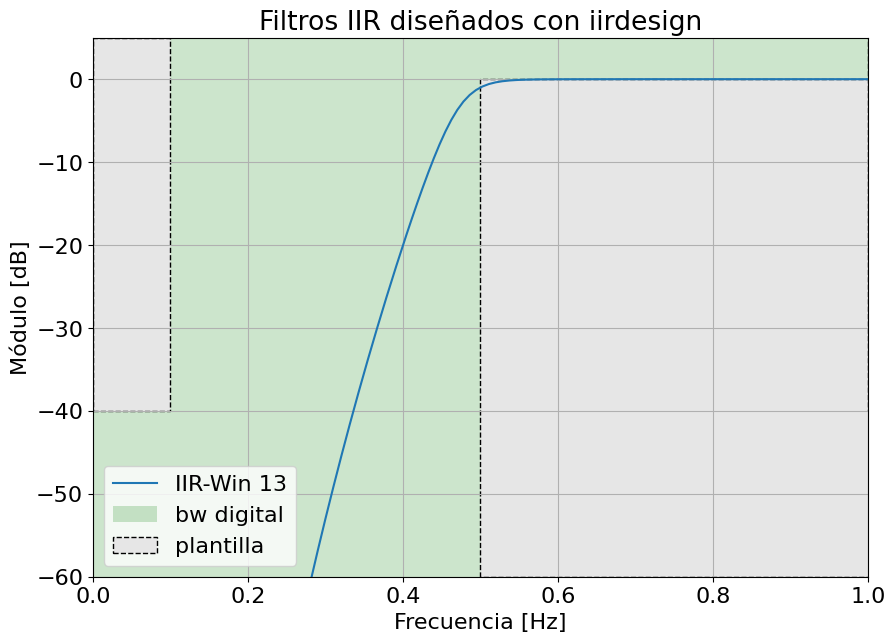

In [48]:
plt.plot(w, 20 * np.log10(abs(h)), label='IIR-Win {:d}'.format(bp_sos_butter.shape[0]))

plt.title('Filtros IIR diseñados con iirdesign')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 1, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)


En el grafico de arriba se puede observar las frecuencias de inferiores del filtro IIR, la cual cumple con la plantilla de diseño pedida. Las frecuencias superiores no fueron graficada porque se ve claramente que cumple con la plantilla.

## Utilizacion de los filtros diseñados

Esta parte se realizo siguiendo los pasos de [Guia de Laboratorio Parte 2](https://nbviewer.org/github/marianux/jupytest/blob/master/Laboratorio%20de%20filtrado%20digital.ipynb)

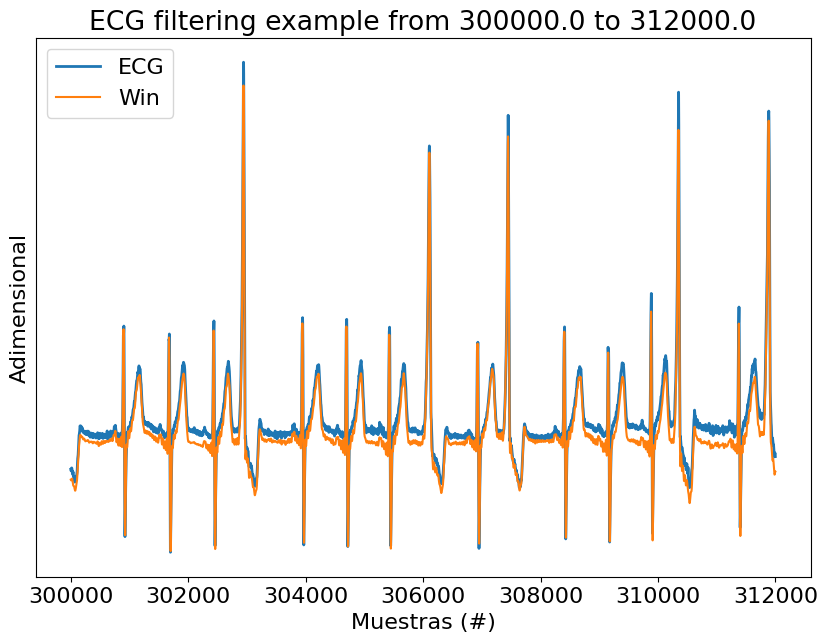

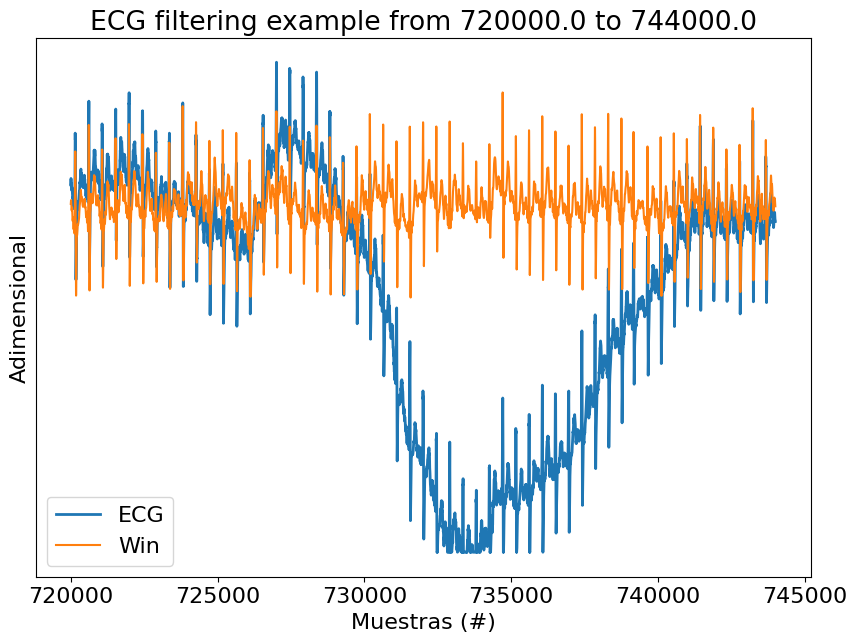

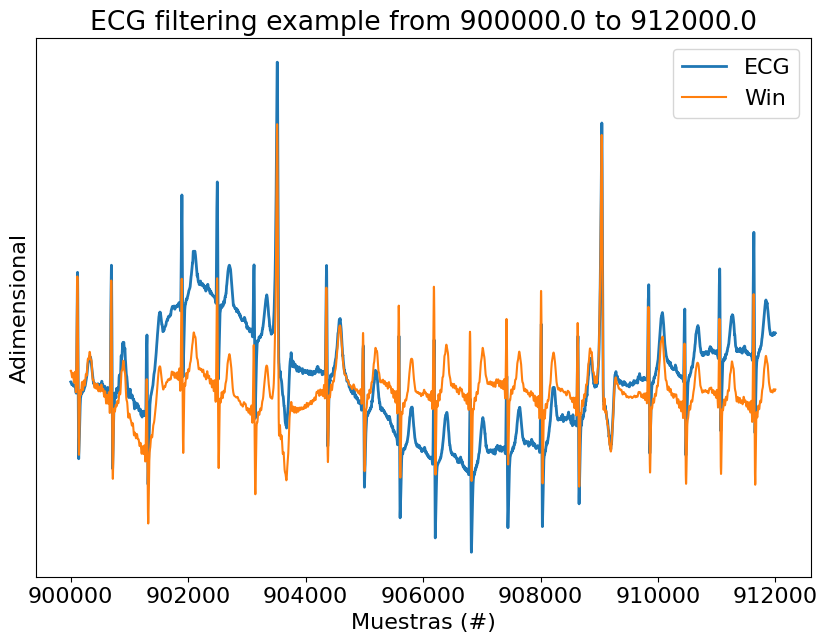

In [49]:
#%% Filtracion de Señales con FIR

# FIR
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

#demora = (cant_coeficientes - 1) // 2
demora = (5451 + 4901) //2

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


En el grafico de arriba se graficaron las zonas de **alta contaminación** para evaluar qué tan eficiente es el filtrado. En este caso se utilizo un filtro FIR para realizar el filtrado y se realizo una demora para que la señal ECG y la señal filtrada queden sincronizada. Se puede observar que el filtro FIR no suaviza las zonas con mas ruido, pero si corrige los dezplazamiento de la señal ECG centrandola.

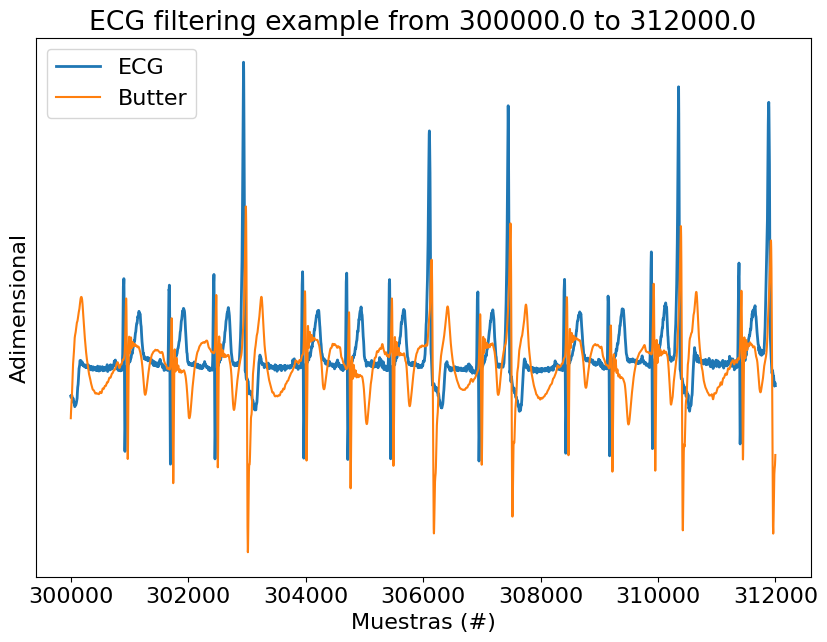

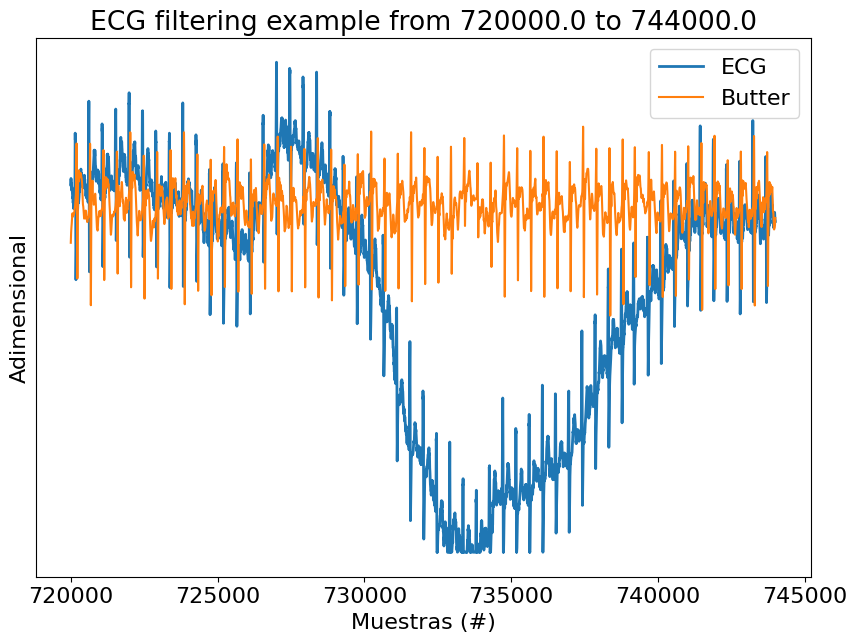

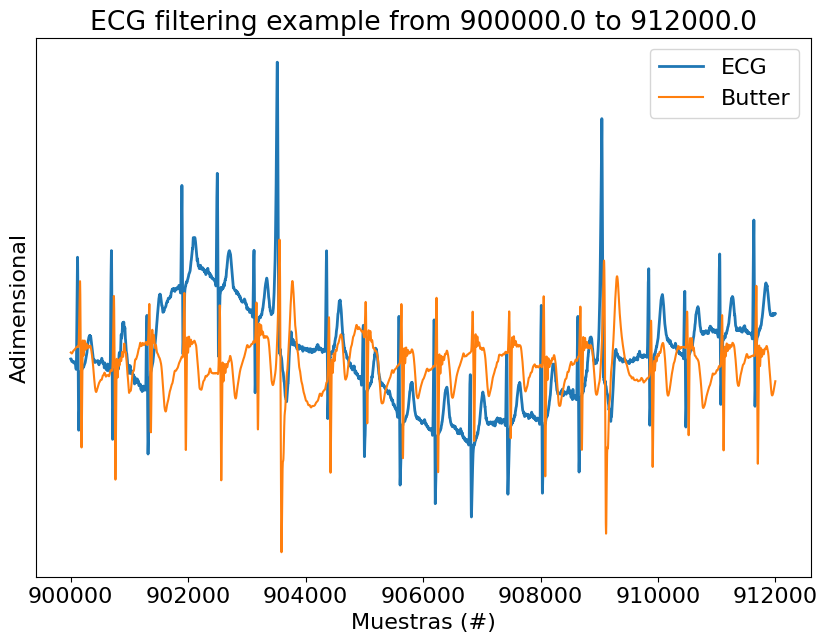

In [50]:
#%% Filtracion de Señal con IIR 

ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    # plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
    

En el grafico de arriba se realizo el filtrado de la señal ECG con un filtro IIR en las zonas de alta contaminacion para evaluar la eficiencia. Se puede observar que el filtro IIR al igual que el filtro FIR no suaviza las zonas con mayor ruido pero si centraliza la señal ECG. Otra observacion es que atenua los picos QRS.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos con **baja contaminación**, es decir qué tan **inocuo** es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

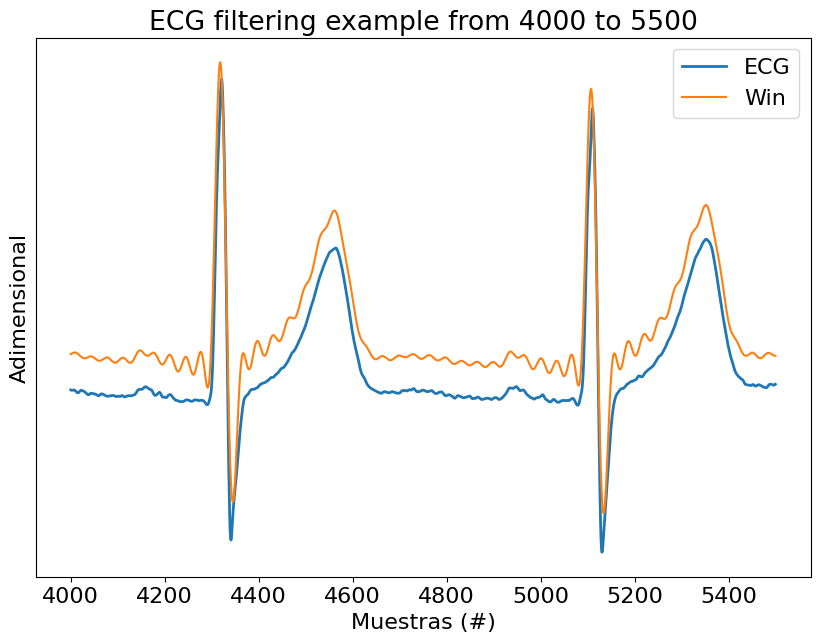

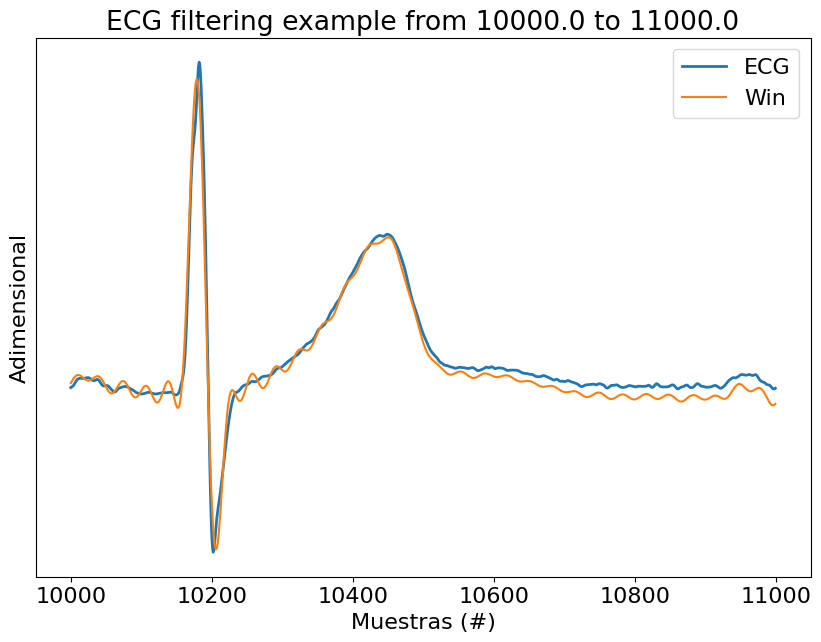

In [51]:
#%% Analisis de contaminación de baja frecuencia
    
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

En el grafico de arriba se realizo el filtrado con el filtro FIR.

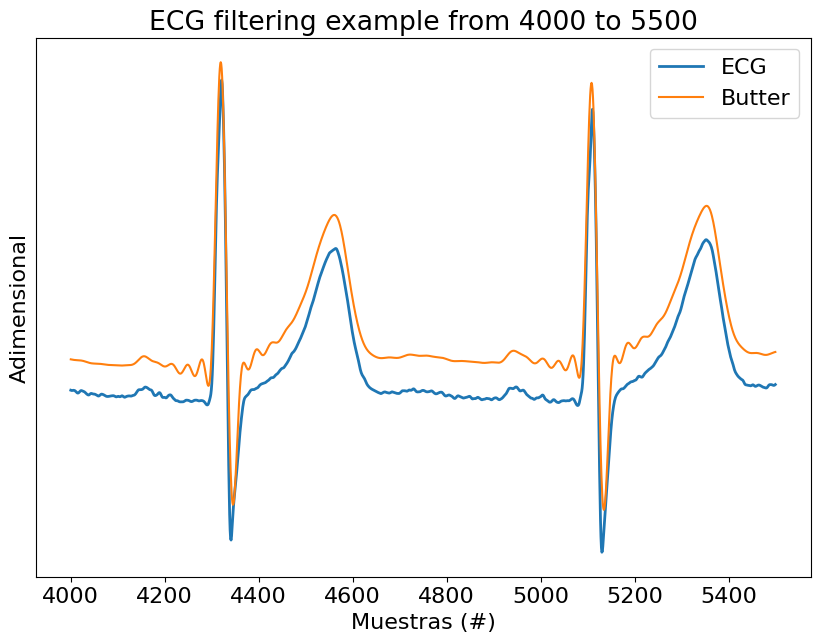

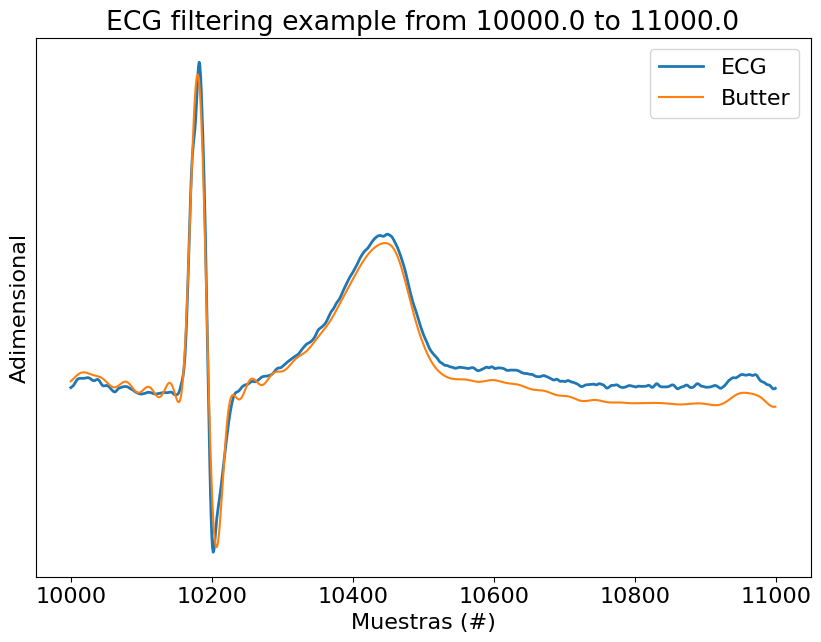

In [57]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Se repitio el filtrado pero ahora con el filtro IIR.

Finalmente implementaremos los mismos filtros con una técnica diferente llamada filtrado bidireccional [scipy.signal.filtfilt.](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html)

El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorsiones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o simpar), no producen distorsión de fase debido a que su fase **es lineal**.

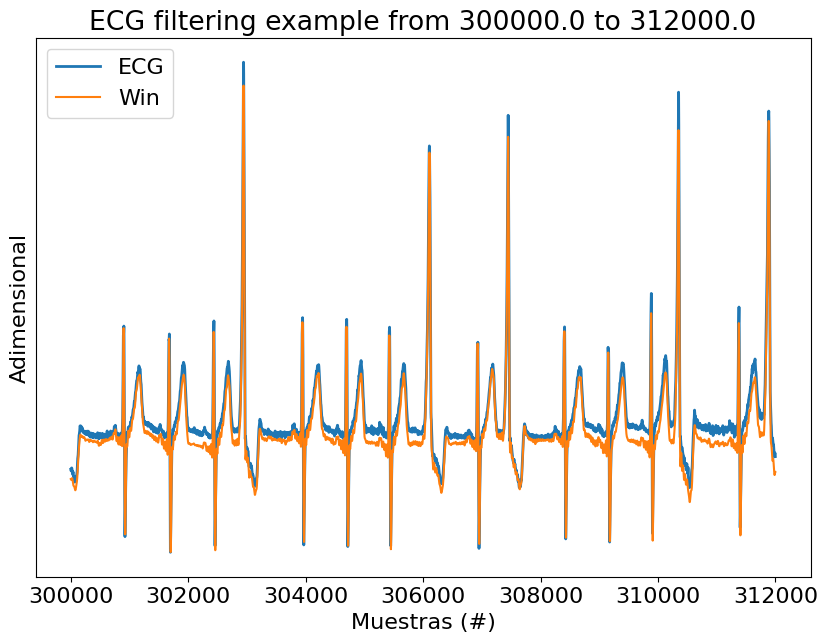

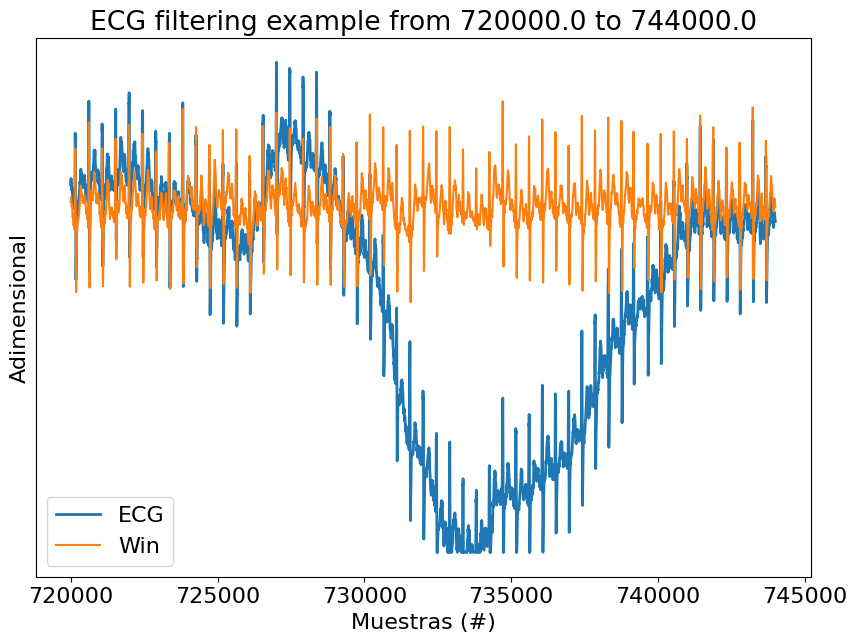

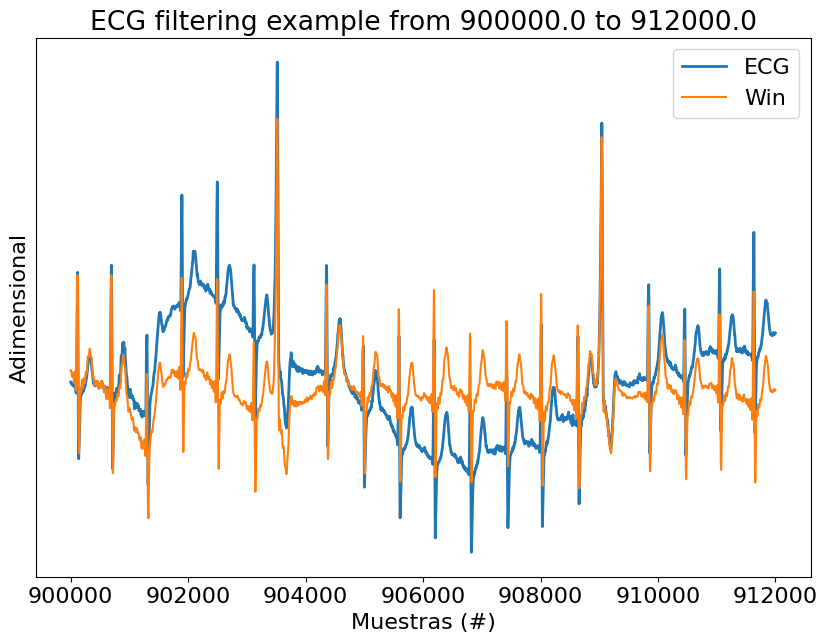

In [53]:
#%% filtrado bidireccional scipy.signal.filtfilt. FIR

# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

En los grafico de arriba se puede observar el filtrado bidireccional, es un filtrado lineal que se realiza dos veces una hacia adelante y otra hacia atras. Es un filtro de fase lineal. Comparandolo con el filtro FIR utilizado mas arriba no hay grandes diferencias ya que el filtro FIR usado tambien tiene fase lineal.

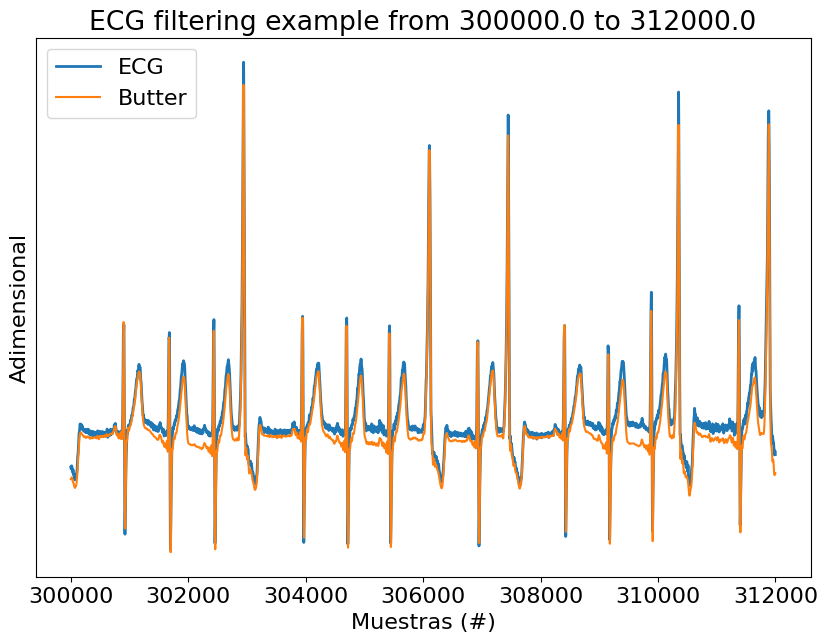

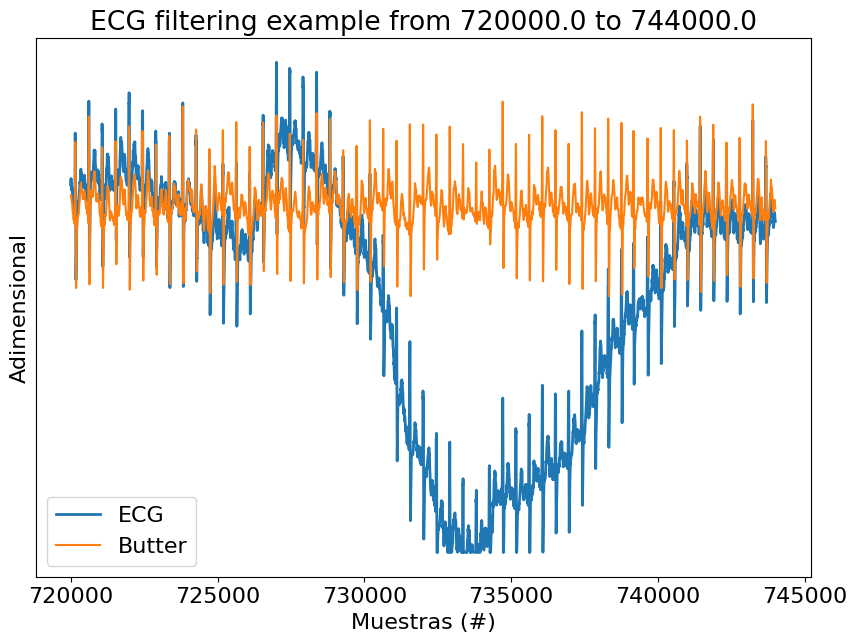

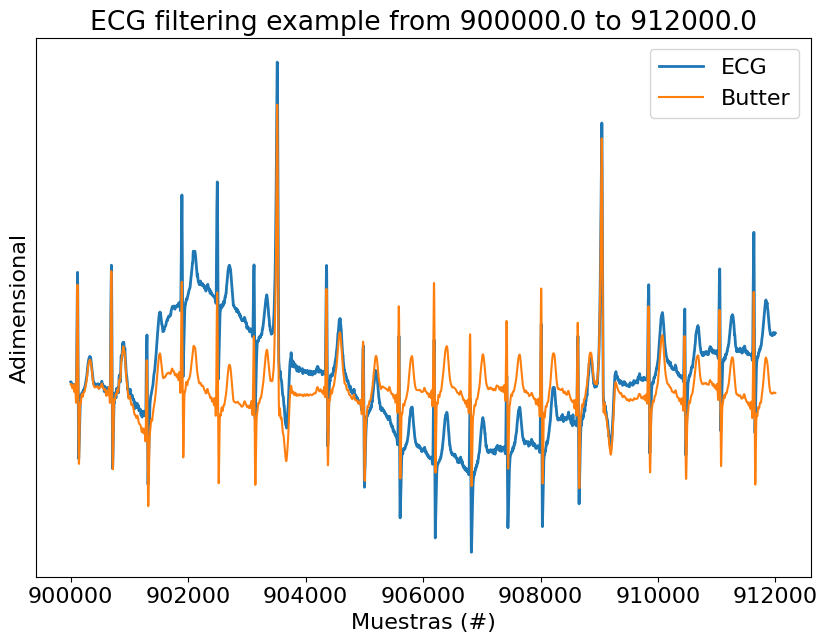

In [54]:
#%% filtrado bidireccional scipy.signal.filtfilt. IIR

# Procedemos al filtrado
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

# ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    # plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

En el grafico de arriba se observa el filtrado bidirecional, comparandolo con el filtro IIR utilizado mas arriba se puede observar una mejora notable en el filtrado esto se debe a que los filtros IIR no tienen fase lineal y al hacer el filtrado combinado obtiene la fase lineal.

Volvemos a revisar los detalles menos contaminados:

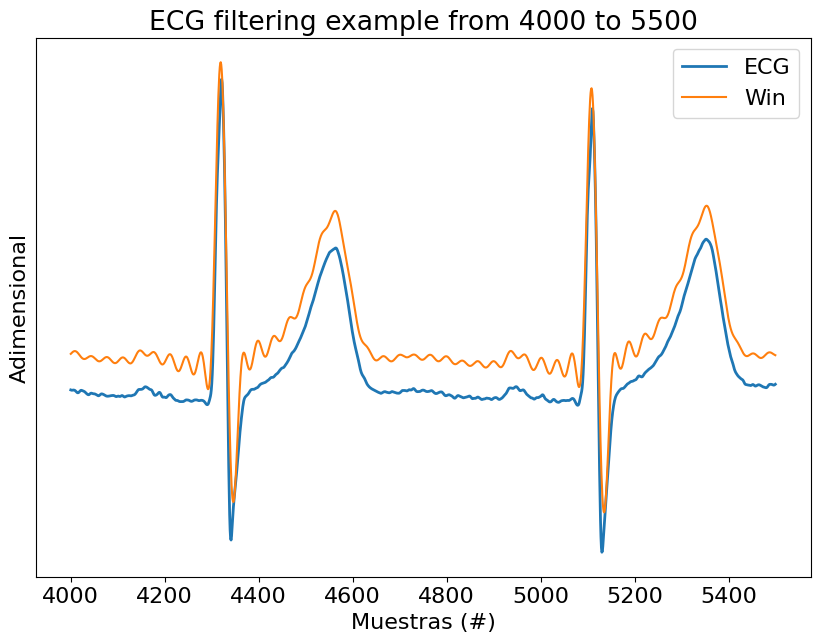

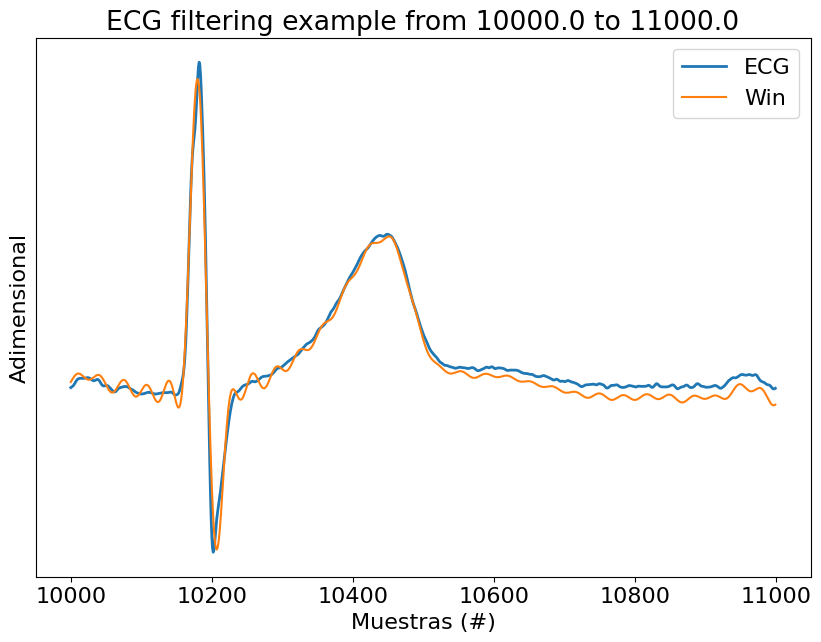

In [55]:
#%% Volvemos a revisar los detalles menos contaminados FIR

regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

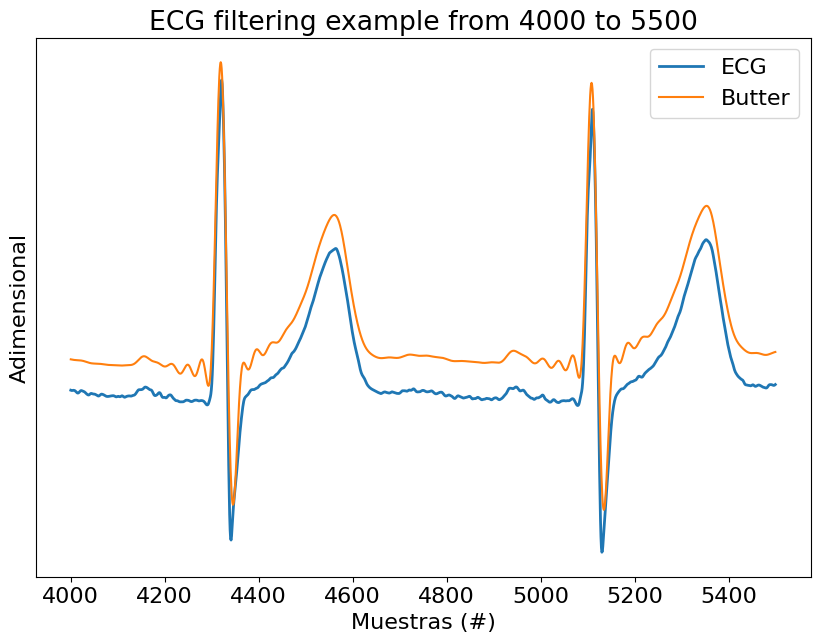

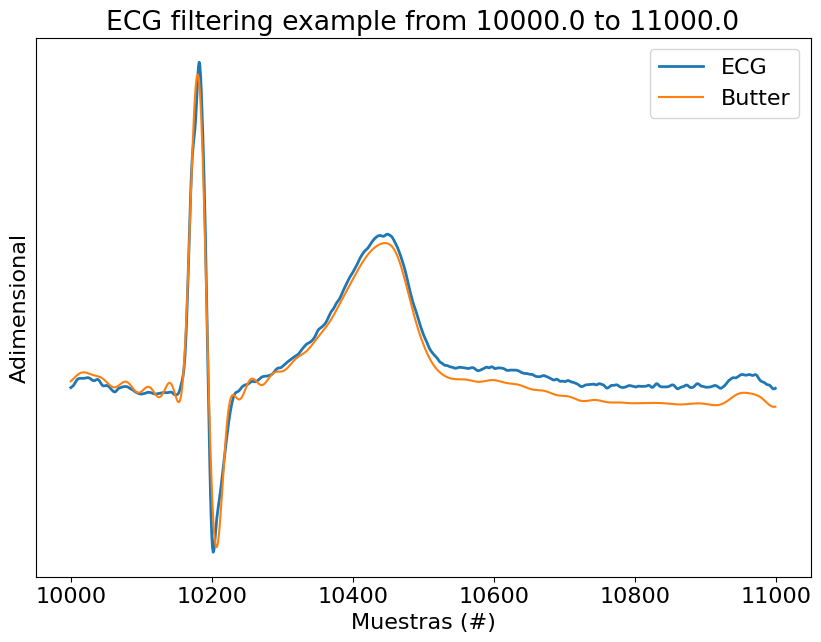

In [56]:
#%% Volvemos a revisar los detalles menos contaminados IIR

regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    #plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Cuestionario

1. ¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?
2. ¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?

1. Los filtros digitales utilizado fueron eficientes para eliminar las interferencias de alta y baja frecuencia. Habiendo realizado un zoom en las zonas de interes se logra aprecir como los filtros suavizan la señal en las zonas de interferencia. 

2. Esto se debe al tipo de señal que estamos analizando, los filtros lineales no esta preparados para cambios tan abruptos en las señales. Por lo que se requiere de filtros que puedan adaptarse a la forma de la señal como son los filtros no lineales.
Ademas, en las zonas con transiciones mas abruptas se generan oscilaciones debido la respuesta que tiene este tipo de señal que son similares a las que se generan en la respuesta al escalon o respuesta al impulso, primero se genera un overshoot y despues requieren de un tiempo para estabilizarse generando esas oscilaciones. Esto hace que cambie un poco la morfologia de la señal ECG cuando es filtrada y se nota mas cuando se observa la zona menos contaminada.